# EM for MLE and MAP

### The Target Distribution
Recall that in our model, we suppose that our data, $\mathbf{X}=\{\mathbf{x}_1, \ldots, \mathbf{x}_K\}$ is drawn from the mixture of $K$ number of Gaussian distributions. For each observation $\mathbf{x}_n$ we have a latent variable $\mathbf{z}_n$ that is a 1-of-$K$ binary vector with elements $z_{nk}$. We denote the set of latent variable by $\mathbf{Z}$. Recall that the distibution of $\mathbf{Z}$ given the mixing coefficients, $\pi$, is given by
\begin{align}
p(\mathbf{Z} | \pi) = \prod_{n=1}^N \prod_{k=1}^K \pi_k^{z_{nk}} 
\end{align}
Recall also that the likelihood of the data is given by,
\begin{align}
p(\mathbf{X} | \mathbf{Z}, \mu, \Sigma) =\prod_{n=1}^N \prod_{k=1}^K \mathcal{N}\left(\mathbf{x}_n| \mu_k, \Sigma_k\right)^{z_{nk}}
\end{align}
Finally, in our basic model, we choose a Dirichlet prior for $\pi$ 
\begin{align}
p(\pi) = \mathrm{Dir}(\pi | \alpha_0) = C(\alpha_0) \prod_{k=1}^K \pi_k^{\alpha_0 -1},
\end{align}
where $C(\alpha_0)$ is the normalizing constant for the Dirichlet distribution. We also choose a Normal-Inverse-Wishart prior for the mean and the covariance of the likelihood function
\begin{align}
p(\mu, \Sigma) = p(\mu | \Sigma) p(\Sigma) = \prod_{k=1}^K \mathcal{N}\left(\mu_k | \mathbf{m}_0, \mathbf{V}_0\right) IW(\Sigma_k|\mathbf{S}_0, \nu_0).
\end{align}
Thus, the joint distribution of all the random variable is given by
\begin{align}
p(\mathbf{X}, \mathbf{Z}, \pi, \mu, \Sigma) = p(\mathbf{X} | \mathbf{Z}, \mu, \Sigma) p(\mathbf{Z} | \pi) p(\pi) p(\mu | \Sigma) p(\Sigma)
\end{align}

### EM for MLE

#### E-step:
*Needs exposition*
\begin{align}
r_{nk} = \frac{\pi_k p\left(\mathbf{x}_n | \mu_k, \Sigma_k\right)}{\sum_{k'=1}^K \pi_{k'} p\left(\mathbf{x}_n | \mu_{k'}, \Sigma_{k'}\right)}
\end{align}

#### M-step:
*Needs exposition*
\begin{align}
\pi_k &= \frac{r_k}{N},\;\; r_k =\sum_{n=1}^N r_{nk}\\
\mu_k &=\frac{\sum_{n=1}^N r_{nk}\mathbf{x}_n}{r_k}\\
\Sigma_k &= \frac{\sum_{n=1}^N r_{nk} \mathbf{x}_n\mathbf{x}_n^\top}{r_k} - \mu_k\mu_k^\top
\end{align}

### EM for MAP

#### E-step:
*Needs exposition*
\begin{align}
r_{nk} = \frac{\pi_k p\left(\mathbf{x}_n | \mu_k, \Sigma_k\right)}{\sum_{k'=1}^K \pi_{k'} p\left(\mathbf{x}_n | \mu_{k'}, \Sigma_{k'}\right)}
\end{align}

#### M-step:
*Needs exposition*
\begin{align}
\pi_k &= \frac{r_k + \alpha_k - 1}{N + \sum_{k=1}^K \alpha_k - K},\;\; r_k =\sum_{n=1}^N r_{nk}\\
\hat{\mu}_k &=\frac{r_k \overline{\mathbf{x}}_k + \beta_0 \mathrm{m}_0}{r_k + \beta_0}\\
\overline{\mathbf{x}}_k&= \frac{\sum_{n=1}^N r_{nk} \mathbf{x}_n}{r_k}\\
\hat{\Sigma}_k &= \frac{\mathbf{S}_0 + \mathbf{S}_k + \frac{\beta_0r_k}{\beta_0 + r_k}(\overline{\mathbf{x}}_k - \mathbf{m}_0)(\overline{\mathbf{x}}_k - \mathbf{m}_0)^\top}{\nu_0 + r_k + D + 2}\\
\mathbf{S}_k &= \sum_{n=1}^N r_{nk} (\mathbf{x}_n - \overline{\mathbf{x}}_k)(\mathbf{x}_n - \overline{\mathbf{x}}_k)^\top
\end{align}


In [147]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib notebook

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
from scipy.stats import gaussian_kde
from scipy.interpolate import spline
from scipy.io import loadmat, savemat
import pandas as pd
import pymc as pm
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from scipy.stats import multivariate_normal as MVN

import re
import numpy as np

In [3]:
#------------------    Real Data    ----------------------#
t1 = time.time()
requests = pd.read_csv('311__Service_Requests.csv')
t2 = time.time()
print "Read in data in %.2f seconds." % (t2 - t1)

t1 = time.time()
closed_requests = requests[requests['CASE_STATUS'] == 'Closed']
t2 = time.time()
print "Filtered data in %.2f seconds." % (t2 - t1)


t1 = time.time()
for col in ['OPEN_DT', 'TARGET_DT', 'CLOSED_DT']:
    closed_requests[col] = pd.to_datetime(closed_requests[col], infer_datetime_format=True)
t2= time.time()
print "Dates processed in %.2f seconds." % (t2 - t1)

Read in data in 9.11 seconds.
Filtered data in 0.27 seconds.

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Dates processed in 391.68 seconds.


In [91]:
########################################
########################################
#####        Make real data        #####
########################################
########################################

def real_data(begin_date, end_date, source, landmark_date, reason=None):
    begin = pd.to_datetime(begin_date) 
    end = pd.to_datetime(end_date)

    in_range = closed_requests[closed_requests['OPEN_DT'] > begin]
    in_range = in_range[in_range['OPEN_DT'] < end]
    in_range = in_range[in_range['Source'] == source]
    if reason is not None:
        in_range = in_range[in_range['REASON'] == reason]
    
    elapsed_time = in_range['CLOSED_DT'].values - in_range[landmark_date].values
    elapsed_time = elapsed_time.astype('timedelta64[h]').astype('float64')

    data = np.hstack((elapsed_time.reshape((len(in_range), 1)), 
                      in_range['LATITUDE'].values.reshape((len(in_range), 1)), 
                      in_range['LONGITUDE'].values.reshape((len(in_range), 1))))
    return data

In [5]:
########################################
########################################
#####       Makes test data        #####
########################################
########################################

def test_data(N, D):
    n_samples = int(N/2.0) #number of points in each component
    mu1 = np.array([10] * D) #mean of component 1
    mu2 = np.array([6] * D) #mean of component 1

    # generate random sample, two components
    np.random.seed(0)

    # generate spherical data centered on mu1
    comp1 = np.random.randn(n_samples, D) + mu1
    
    # generate spherical data centered on mu2
    comp2 = np.random.randn(N - n_samples, D) + mu2

    # concatenate the two datasets into training set
    data = np.vstack([comp1, comp2])

    #plot the components
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(comp1[:, 0], comp1[:, 1], comp1[:, 2], c='r')
    ax.scatter(comp2[:, 0], comp2[:, 1], comp2[:, 2], c='b')

    plt.title('test data')
    plt.show()
    
    return data

In [68]:
########################################
########################################
###   K-means init for mu and Sigma  ###
########################################
########################################

def k_means(N, D, K, X):
    kmeans = KMeans(init='random', n_clusters=K) #k-means++
    kmeans.fit(data)
    mu = kmeans.cluster_centers_
    labels = kmeans.predict(X)
    
    clusters = [labels[labels == k].shape[0] for k in xrange(K)]    
    pi = np.array([clusters[k] / (1. * sum(clusters)) for k in xrange(K)])
    
    clusters = [[X[n] for n in xrange(N) if labels[n] == k] for k in xrange(K)]
    
    Sigma = []
    for k in xrange(K):
        Sigma_k = np.zeros((D, D))
        for pt in clusters[k]:
            Sigma_k += np.outer(pt, pt)
        Sigma.append(Sigma_k - len(clusters[k]) * np.outer(mu[k], mu[k]))
        
    return pi, mu, Sigma

In [7]:
########################################
########################################
#####         EM for MLE           #####
########################################
########################################

def MLE_EM(K, D, N, X, pi_0, mu_0, Sigma_0, iters):
    
    #initialization of parameters    
    r = np.zeros((N, K)) #responsibility of each cluster for each data pt
    pi = pi_0 #mixture coefficients
    mu = mu_0 #means (K x D) matrix
    Sigma = Sigma_0 #coveriances length-k list of (K x K) matrices
    
    #---------------- Likelihood ----------------#    
    def lkhd(pi, mu, Sigma):
        prob = np.zeros((N, K))
        for k in xrange(K):
            prob[:, k] = pi[k] * MVN.pdf(X, mu[k, :], Sigma[k])
        return np.nan_to_num(prob)
    
    #---------------- E-Step ----------------#
    def E_step():
        prob = lkhd(pi, mu, Sigma) 
        return np.nan_to_num(np.diag(np.reciprocal(np.sum(prob, axis=1))).dot(prob))
    
    #---------------- M-Step ----------------#
    def M_step():
        r_ks = np.sum(r, axis=0)
        pi_new = 1. / N * r_ks
        mu_new = np.nan_to_num(np.diag(np.reciprocal(r_ks)).dot(r.T.dot(X)))
        
        Sigma_new = []
        for k in xrange(K):
            Sigma_k = np.zeros((D, D))
            for n in xrange(N):
                Sigma_k += r[n, k] * np.outer(X[n, :] - mu[k, :], X[n, :] - mu[k, :])
            Sigma_new.append(np.nan_to_num(Sigma_k / r_ks[k]))
            
        return pi_new, mu_new, Sigma_new
    
    #---------------- Alternate Between E and M-steps ----------------#
    for i in xrange(iters):        
        r = E_step()
        pi, mu, Sigma = M_step()
        
    r = E_step()
    
    return pi, mu, Sigma, r

########################################
########################################
#####         EM for MAP           #####
########################################
########################################

def MAP_EM(K, D, N, X, pi_0, mu_0, Sigma_0, S_0, m_0, nu_0, beta_0, alpha_0, iters):
    
    #initialization of intermediate parameters
    r = np.zeros((N, K)) #responsibility of each cluster for each data pt
    pi = pi_0 #mixture coefficients
    mu = mu_0 #means (K x D) matrix
    Sigma = Sigma_0 #coveriances length-k list of (K x K) matrices
    S = [np.eye(D) for k in xrange(K)] #(K x K) scatter matrices
    X_mean = mu_0 #mean of pts in each cluster (K x D) matrix
    
    #---------------- Likelihood ----------------#    
    def lkhd(pi, mu, Sigma):
        prob = np.zeros((N, K))
        for k in xrange(K):
            prob[:, k] = pi[k] * MVN.pdf(X, mu[k, :], Sigma[k]) 
        return prob
    
    #---------------- E-Step ----------------#
    def E_step():
        prob = lkhd(pi, mu, Sigma) 
        return np.diag(np.reciprocal(np.sum(prob, axis=1))).dot(prob)
        
    
    #---------------- M-Step ----------------#
    def M_step():
        r_ks = np.sum(r, axis=0)
        pi_new = (r_ks + alpha_0 - 1) * 1. / (N + np.sum(alpha_0) - K)
        X_mean_new = np.nan_to_num(np.diag(np.reciprocal(r_ks)).dot(r.T.dot(X)))
        mu_new = np.nan_to_num(np.diag(np.reciprocal(r_ks 
                                                     + beta_0)).dot(np.diag(r_ks).dot(X_mean) 
                                                                    + beta_0 * m_0))
        S_new = []
        Sigma_new = []
        for k in xrange(K):            
            c_1 = (beta_0 * r_ks[k]) / (beta_0 + r_ks[k])
            c_2 = nu_0 + r_ks[k] + D + 2
            Sigma_k = np.nan_to_num(S_0 + S[k] + c_1 
                                    * np.outer(X_mean[k, :] - m_0, X_mean[k, :] - m_0))
            Sigma_new.append(Sigma_k * 1./c_2)
            
            S_k = np.zeros((D, D))
            for n in xrange(N):
                S_k += r[n, k] * np.outer(X[n, :] - X_mean[k, :], X[n, :] - X_mean[k, :])
                
            S_new.append(S_k)
        return pi_new, X_mean_new, mu_new, S_new, Sigma_new
        
    #---------------- Alternate Between E and M-steps ----------------#
    for i in xrange(iters): 
        r = np.nan_to_num(E_step())
        pi, X_mean, mu, S, Sigma = M_step()
        
    r = E_step()
    
    return pi, X_mean, mu, S, Sigma, r

In [8]:
########################################
########################################
#####       Plot clusters          #####
########################################
########################################
def plot_clusters(data_std, r, K, title):
    
    for n in xrange(N):
        r_n = r[n, :]
        r_n[r_n < np.max(r_n)] = 0
        r_n[r_n == np.max(r_n)] = 1
        r[n, :] = r_n
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    clusters = [np.asarray([data_std[n] for n in xrange(N) if r[n, k] == 1]) for k in xrange(K)]

    values = np.linspace(0, 1, K)
    cm = plt.get_cmap('rainbow') 
    cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

    for k in xrange(K):    
        colorVal = scalarMap.to_rgba(values[k])
        ax.scatter(clusters[k][:, 0], clusters[k][:, 1], clusters[k][:, 2], c=colorVal)
   
    plt.title(title)
    plt.show()

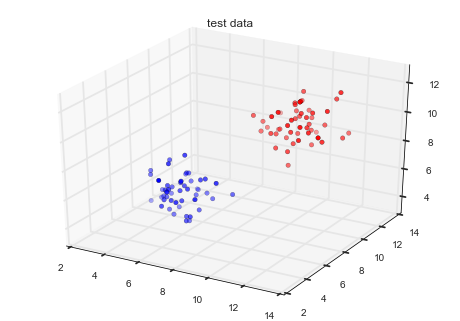

******************* K-means
mixture: [ 0.5  0.5]
mu [[  5.92168648   6.00042586   5.86691424]
 [ 10.27935454  10.21207876   9.88471757]]
Sigma: [[ 46.12307462  -8.74191667   3.34517806]
 [ -8.74191667  45.15409447  -7.48072604]
 [  3.34517806  -7.48072604  49.68106486]]
Sigma: [[ 55.95336916  -0.63653443   7.65032885]
 [ -0.63653443  50.16360724   5.18890337]
 [  7.65032885   5.18890337  45.56551815]]
******************* MLE
mixture: [ 0.49999898  0.50000102]
mu [[  5.92168214   6.00042366   5.86691412]
 [ 10.27935003  10.2120724    9.88470953]]
Sigma: [[ 0.92245377 -0.17484352  0.06690379]
 [-0.17484352  0.90308079 -0.14961433]
 [ 0.06690379 -0.14961433  0.9936225 ]]
Sigma: [[ 1.11907542 -0.01271641  0.15302376]
 [-0.01271641  1.00329059  0.10380241]
 [ 0.15302376  0.10380241  0.91134115]]


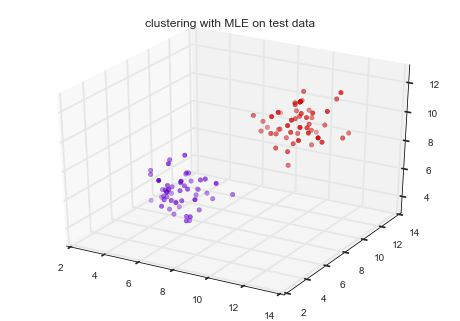

******************* MAP
mixture: [ 0.49816281  0.50183719]
mu [[  5.88727241   5.96637959   5.83403583]
 [ 10.22022658  10.15264193   9.82683254]]
Sigma: [[ 0.96145564  0.01773731  0.22000006]
 [ 0.01773731  0.95146156  0.03888805]
 [ 0.22000006  0.03888805  1.02108348]]
Sigma: [[ 1.4661053   0.48853655  0.61333719]
 [ 0.48853655  1.36478123  0.57054913]
 [ 0.61333719  0.57054913  1.2577051 ]]


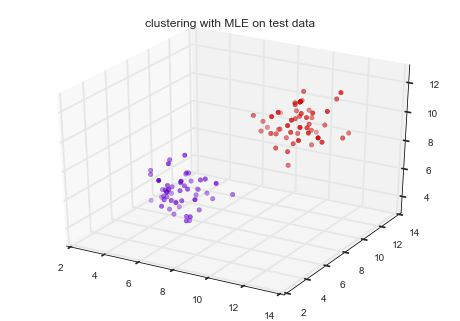

In [10]:
########################################
########################################
#####     Run on test data         #####
########################################
########################################

#-------------   run parameters
iters = 500

#-------------   test data parameters
K = 2 #number of components
N = 100 #number of observations
D = 3 #number of attributes per observation

data = test_data(N, D) #make test data

#---------------- K-means initialization for MLE ----------------#
N = data.shape[0] #number of observations
K = 2 #number of components
D = data.shape[1] #number of features per observation

pi, mu, Sigma = k_means(N, D, K, data)

print '******************* K-means'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]


#---------------- MLE ----------------#
pi, mu, Sigma, r = MLE_EM(K, D, N, data, pi, mu, Sigma, iters)

print '******************* MLE'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]

#plot the components
plot_clusters(data, r, K, 'clustering with MLE on test data')


#---------------- MAP ----------------#

#random initialization of hyperparameters
alpha_0 = np.random.random(K)
beta_0 = np.random.random()
m_0 = np.zeros(D)
S_0 = np.eye(D)
nu_0 = D + 1

pi, X_mean, mu, S, Sigma, r = MAP_EM(K, D, N, data, pi, mu, Sigma, S_0, m_0, nu_0, beta_0, alpha_0, iters)

print '******************* MAP'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]

#plot the components
plot_clusters(data, r, K, 'clustering with MLE on test data')

(102026, 3)


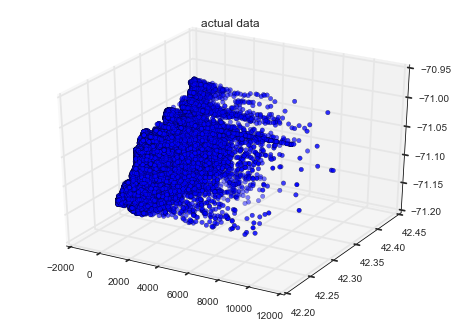

In [79]:
########################################
########################################
#####     Run on real data         #####
########################################
########################################

data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                 'Constituent Call', 'OPEN_DT')
#data_std = scale(data)
#data_norm = normalize(data)
print data.shape

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='b')

plt.title('actual data')
plt.show()

#---------------- K-means initialization for MLE ----------------#
N = data.shape[0] #number of observations
K = 2 #number of components
D = data.shape[1] #number of features per observation

#pi, mu, Sigma = k_means(N, D, K, data_std)

#print '******************* K-means'
#print 'mixture:', pi
#print 'mu', mu
#print 'Sigma:', Sigma[0]
#print 'Sigma:', Sigma[1]


******************* MLE
mixture: [ 0.83707761  0.16292239]
mu [[ 0.04019663  0.08364823  0.33016568]
 [-0.20652594 -0.42977553 -1.69635547]]
Sigma: [[ 0.95900931  0.01721442 -0.02014016]
 [ 0.01721442  0.90469961  0.38323629]
 [-0.02014016  0.38323629  0.47966099]]
Sigma: [[ 1.1596511   0.3131255  -0.01679696]
 [ 0.3131255   1.26898613 -0.07974165]
 [-0.01679696 -0.07974165  0.2357452 ]]


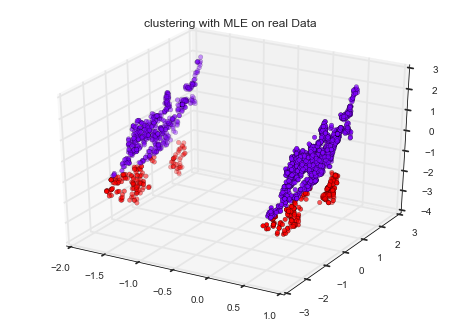

In [67]:
#---------------- Data parameters ----------------#
N = data.shape[0] #number of observations
K = 2 #number of components
D = data.shape[1] #number of features per observation

#---------------- MLE ----------------#

#initialization of parameters
pi = np.array([1./K] * K)
mu_ind = np.random.randint(len(data_std), size=K)
mu_ind = [372,  34]
mu = np.asarray([data_std[mu_ind[k]] for k in xrange(K)])

Sigma = [100. * np.eye(D) for k in xrange(K)] 

#run EM for MLE estimate
pi, mu, Sigma, r = MLE_EM(K, D, N, data_std, pi, mu, Sigma, iters)

print '******************* MLE'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]

#plot the components
plot_clusters(data_std, r, K, 'clustering with MLE on real Data')

[ 0.88739712  0.26569602]
0.334538339401
[372, 34]
******************* MAP
mixture: [ 0.80031159  0.19968841]
mu [[ 0.07234433  0.11251473  0.36198956]
 [-0.28943896 -0.45015481 -1.44826673]]
Sigma: [[ 0.96523926 -0.01255694 -0.04786699]
 [-0.01255694  0.94331493  0.37870256]
 [-0.04786699  0.37870256  0.51524236]]
Sigma: [[ 1.35895586  0.29639719 -0.08738289]
 [ 0.29639719  1.29937704 -0.08626114]
 [-0.08738289 -0.08626114  0.6603372 ]]


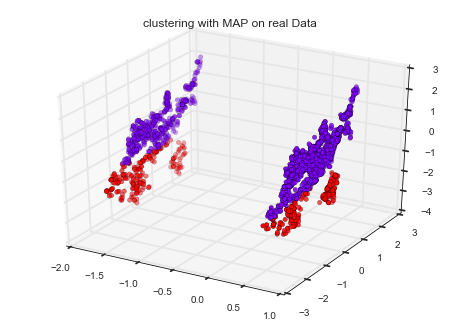

In [66]:
#---------------- Data parameters ----------------#
N = data.shape[0] #number of observations
K = 2 #number of components
D = data.shape[1] #number of features per observation

#---------------- MAP ----------------#

#random initialization of hyperparameters
alpha_0 = np.random.random(K)
print alpha_0
#alpha_0 = np.array([ 0.7480228,   0.79356737]) #k=2
#alpha_0 = np.array([ 0.4733262,   0.67512591,  0.02135868]) #k=3
beta_0 = np.random.random()
print beta_0
#beta_0 = 0.300651158697 #k=2
#beta_0 = 0.102316815888 #k=3
m_0 = np.zeros(D)
S_0 = 100 * np.eye(D)
nu_0 = D + 1

#initialization of parameters
pi = np.array([1./K] * K)
mu_ind = np.random.randint(len(data_std), size=K)
mu_ind = [372,  34] #k=2
#mu_ind = [240, 367, 198] #k=3
print mu_ind
mu = np.asarray([data_std[mu_ind[k]] for k in xrange(K)])

Sigma = [100. * np.eye(D) for k in xrange(K)] 

#run EM for MAP estimate
pi, X_mean, mu, S, Sigma, r = MAP_EM(K, D, N, data_std, pi, mu, Sigma, S_0, m_0, nu_0, beta_0, alpha_0, iters)

print '******************* MAP'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]
    
#plot the components
plot_clusters(data_std, r, K, 'clustering with MAP on real Data')

In [143]:
data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                 'Constituent Call', 'OPEN_DT')
savemat('2015_data_by_open.mat', {'data': data})

data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                 'Constituent Call', 'TARGET_DT')
savemat('2015_data_by_target.mat', {'data': data})

In [144]:
days = pd.date_range('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM')

in_range = closed_requests[closed_requests['Source'] == 'Constituent Call']
in_range = in_range[in_range['OPEN_DT'] > days[0]]
in_range = in_range[in_range['OPEN_DT'] < days[-1]]

reasons = list(set((in_range['REASON'].values).tolist()))

reason_count = []
for reason in reasons:
     reason_count.append((reason, len(reason_range['OPEN_DT'].values)))

reasons = sorted(reason_count, key=lambda t: t[1])


by_reasons = []
for reason, count in reasons:
    reason_count = []
    reason_range = in_range[in_range['REASON'] == reason]
    for n in xrange(len(days) - 1):
        reason_dates = reason_range[reason_range['OPEN_DT'] > days[n]]
        reason_dates = reason_dates[reason_dates['OPEN_DT'] < days[n + 1]]  
        reason_count.append(len(reason_dates) + 0.5)
    by_reasons.append(reason_count)

savemat('2015_data_by_reason.mat', {'data': by_reasons}) 


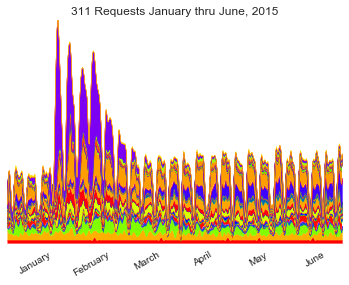

In [148]:
by_reasons = loadmat('2015_data_by_reason.mat')['data'][:, :182]
x = np.linspace(0, len(by_reasons[0]), len(by_reasons[0]))

adjusted = np.zeros(by_reasons.shape)

for i in xrange(len(by_reasons)):
    for j in xrange(i + 1):
        adjusted[i, :] += by_reasons[j, :]
    adjusted[i, :] += 1
adjusted[0, :] = by_reasons[0, :]

values = np.linspace(0, len(adjusted) + 1, len(adjusted) + 1)
cm = plt.get_cmap('prism') 
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

xnew = np.linspace(x.min(), x.max(), 600)

adjusted_sm = np.zeros((adjusted.shape[0], 600))
for i in xrange(len(adjusted)):
    adjusted_sm[i, :] = spline(x, adjusted[i, :], xnew)

colorVal = scalarMap.to_rgba(values[0])
zero = np.zeros(adjusted_sm.shape[1])
plt.fill_between(xnew, np.sqrt(adjusted_sm[0,:]), zero, color=colorVal)

for i in xrange(1, len(adjusted)):
    colorVal = scalarMap.to_rgba(values[i])
    plt.fill_between(xnew, np.sqrt(adjusted_sm[i,:]), np.sqrt(adjusted_sm[i - 1,:]), color=colorVal)

    
plt.xlim(0, 182)
plt.ylim(0, 47)
frame = plt.gca()
frame.axes.get_yaxis().set_visible(False)
xlabels = [''] * (600)
xlabels[50] = 'January'
xlabels[200 - 50] = 'February'
xlabels[300 - 50] = 'March'
xlabels[400 - 50] = 'April'
xlabels[500 - 50] = 'May'
xlabels[600 - 50] = 'June'
plt.xticks(xnew, xlabels, rotation=30)
sns.despine(left=True, bottom=True, right=True)

plt.title('311 Requests January thru June, 2015')
plt.show()

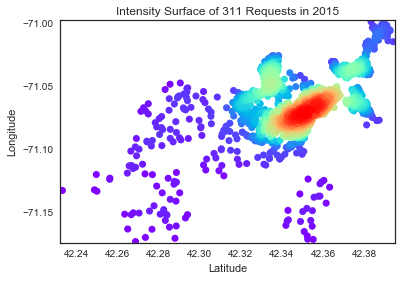

In [149]:
data = loadmat('2015_data_by_open.mat')['data']

x = data[:, 1]
y = data[:, 2]
xy = np.vstack((x, y))
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

values = np.linspace(0, 1, len(idx))
cm = plt.get_cmap('rainbow') 
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
colorVal = scalarMap.to_rgba(values)

fig, ax = plt.subplots()
ax.scatter(x, y, c=colorVal, s=50, edgecolor='')
plt.xlim(min(x) - 1e-3, max(x) + 1e-3)
plt.ylim(min(y) - 1e-3, max(y) + 1e-3)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Intensity Surface of 311 Requests in 2015')
plt.show()